# Demo de implementación de un Algoritmo Memético (Meme Algorithm) junto de Colonia de Abejas para resolver el problema de encontrar un Máximo Óptimo definido al azar en un plano y tratando de esquivar los máximos locales aleatorios
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

0) Preparar el ambiente:

In [ ]:
#@title
!pip install deap

1) Importar librerías:

In [ ]:
#@title
import random
import math
import numpy as np
import matplotlib.pyplot as plt

import copy
import operator

from deap import base
from deap import creator
from deap import tools

import pickle
import codecs

print("\nLibrerías importadas")


Librerías importadas


2) Establecer parámetros generales de la Corrida:

In [ ]:
# Espacio  de búsqueda
CANT_MAXIMOS_LOCALES = 3 #@param {type:"slider", min:0, max:10, step:1}
MIN_ESPACIO_BUSQ = -1000 #@param {type:"slider", min:-1000, max:0, step:5}
MAX_ESPACIO_BUSQ = 1000 #@param {type:"slider", min:0, max:1000, step:10}

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 100  #@param {type:"integer"}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 5 #@param {type:"slider", min:1, max:100, step:1}

# Probabilidad del Cruzamiento (en AG 1 = 100%)
PROBAB_CRUZAMIENTO = 1 

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True #@param {type:"boolean"}

#  Área de las Abejas Exploradoras
RADIO_AREA_EXPLORADORA = 50
PORC_RED_AREA_EXPLORADORA = 0.5
MIN_RADIO_AREA_EXPLORADORA = 2
CANT_ABEJAS_OBRERAS_RECL_ELITE = 15

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


2) Inicializar objetos de DEAP para utilizar e indicar Operadores Genéticos:

In [ ]:
#@title clase MAPA DE BÚSQUEDA
Hash_configuracion_Mapa_Busqueda = "gANjX19tYWluX18KTWFwYUJ1c3F1ZWRhCnEAKYFxAX1xAihYBgAAAGxpbU1pbnEDShj8//9YBgAA AGxpbU1heHEETegDWAcAAABjYW50TWF4cQVLA1gKAAAATWF4aW1vc1Bvc3EGXXEHKF1xCChN3gFK kP///2VdcQkoTRkDSoH///9lXXEKKE0gA0oW/f//ZV1xCyhLhk0KAmVlWAoAAABNYXhpbW9zVmFs cQxdcQ0oS2BLYkshSx1lWAsAAABNYXhPcHRpbW9JRHEOSwF1Yi4=" #@param {type:"string"}

class MapaBusqueda(object):

    def __init__(self, limMin, limMax, cantMaximosLocales=0):
          self.limMin = limMin
          self.limMax = limMax
          self.cantMax = cantMaximosLocales
          self.generarPosicionesRnd()

    def generarPosicionesRnd(self):
      
        # Define Posiciones Random para Máximos Locales y Óptimos
        # con Heurística también al Azar (entre 1 y 100)
        # controla que el máximo local/global no se ubique en la misma posición que el Hormiguero
        self.MaximosPos = []
        self.MaximosVal = []
        self.MaxOptimoID = 0
        auxMejorVal = -99
        i = 0
        while len(self.MaximosPos)<(self.cantMax+1):

            auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]        
            auxVal = random.randint(-20, 100)

            self.MaximosPos.append( auxPos )
            self.MaximosVal.append( auxVal )
            
            if self.MaximosVal[self.MaxOptimoID] < auxVal:
                self.MaxOptimoID = i
            i= i + 1

        return True
   
    def printInformacion(self):
        # Muestra la información sobre el Mapa de Búsqueda
        print("\n** Máximos Generados: ", len(self.MaximosPos))
        for auxPos, auxVal in zip(self.MaximosPos, self.MaximosVal):
            print("  -->", auxPos, "{ ", auxVal, " } ")
        print("\n** Posición Máximo Óptimo: ", self.MaximosPos[self.MaxOptimoID], " { ",  self.MaximosVal[self.MaxOptimoID]," } **")
        print("\n")

    @property
    def posMaximos(self):
        return self.MaximosPos    

    @property
    def valMaximos(self):
        return self.MaximosVal   
        
    @property
    def posMaximoGlobal(self):
        return self.MaximosPos[self.MaxOptimoID]         
    
    @property
    def valMaximoGlobal(self):
        return self.MaximosVal[self.MaxOptimoID]  

    def estaEnMaximo(self, posicion):
      # Indica si la posición corresponde o no a un Máximo 
      # si es verdadero devuelve el valor correspondiente, sino 0
      for i in range(len(self.MaximosPos)):
        if posicion==self.MaximosPos[i]:
          return self.MaximosVal[i]
      return 0

    def funcHeuristica(self, posicion):
        # Define la Función Heurística para evaluar una posicion del mapa
        devuelve = 0
        disPosMenor = self.limMax
        for posMax, valMax in zip(self.MaximosPos, self.MaximosVal):

              # calcula la distancia al punto de la Particula
              sqerrors = ((x - y)**2 for x, y in zip(posicion, posMax))
              distPos =  math.fsum(sqerrors)**0.5 / 10
              
              # Si es la menor distancia calcula la Heurística
              if disPosMenor > distPos:
                  disPosMenor = distPos 
                  devuelve = ( valMax - distPos) 

          # Por las dudas controla que devuelva un valor positivo
        return max(devuelve,0)


print("\nClase Mapa de Búqueda definida") 

# si tiene la configuración definida, la carga sino crea nueva clase
if Hash_configuracion_Mapa_Busqueda != "":
  print("\n> Usando configuración de mapa de búsqueda definida en hash.")
  mapa = pickle.loads(codecs.decode(Hash_configuracion_Mapa_Busqueda.encode(), "base64"))
else:
  # sino define el Mapa de Búsqueda nuevo
  print("\n> Creando nuevo mapa de búsqueda.")
  mapa = MapaBusqueda(limMin=MIN_ESPACIO_BUSQ, limMax=MAX_ESPACIO_BUSQ, \
                      cantMaximosLocales=CANT_MAXIMOS_LOCALES)

print("\n> Mapa de búsqueda definido:")
mapa.printInformacion()

print("\n> Hash del mapa de búsqueda definido: ")
print( codecs.encode(pickle.dumps(mapa), "base64").decode() )


Clase Mapa de Búqueda definida

> Usando configuración de mapa de búsqueda definida en hash.

> Mapa de búsqueda definido:

** Máximos Generados:  4
  --> [478, -112] {  96  } 
  --> [793, -127] {  98  } 
  --> [800, -746] {  33  } 
  --> [134, 522] {  29  } 

** Posición Máximo Óptimo:  [793, -127]  {  98  } **



> Hash del mapa de búsqueda definido: 
gANjX19tYWluX18KTWFwYUJ1c3F1ZWRhCnEAKYFxAX1xAihYBgAAAGxpbU1pbnEDShj8//9YBgAA
AGxpbU1heHEETegDWAcAAABjYW50TWF4cQVLA1gKAAAATWF4aW1vc1Bvc3EGXXEHKF1xCChN3gFK
kP///2VdcQkoTRkDSoH///9lXXEKKE0gA0oW/f//ZV1xCyhLhk0KAmVlWAoAAABNYXhpbW9zVmFs
cQxdcQ0oS2BLYkshSx1lWAsAAABNYXhPcHRpbW9JRHEOSwF1Yi4=



In [ ]:
#@title clase ABEJA

class Abeja(object):
    
    def __init__(self, mapa=None, radioArea=0):
        
        if mapa == None:
            self.pos = []
            self.radio = 0
            self.valor = -9999
        else:        
            self.pos = [random.randint(mapa.limMin, mapa.limMax) for _ in range(2)]
            self.valor = mapa.funcHeuristica(self.pos)
            self.radio = radioArea

    def _reset(self):
        self.pos = []
        self.radio = 0
        self.valor = -9999

    @property
    def heuristica(self):
        return self.valor

    @property
    def posicion(self):
        return self.pos    

    @property
    def tieneArea(self):
        return self.radio>0        

    def reclutarObreras(self, mapa, cantObrerasReclutadas, \
                        radioAreaExpl=RADIO_AREA_EXPLORADORA, \
                        porcRedAreaExpl = PORC_RED_AREA_EXPLORADORA, \
                        minAreaExpl=MIN_RADIO_AREA_EXPLORADORA):
        
        # Si el radio del área es nulo, no se generan
        if self.radio <= 0:
            return []

        obrerasReclutadasNuevas = []
        algunaObreraMejor = False
        for i in range(cantObrerasReclutadas):

              # Crea una nueva abeja a la que le asigna una posción relativa a la exploradora padre
              # y luego calcula su herística
              nOb = Abeja()
              for i in range(len(self.pos)):
                  nOb.pos.append( random.randint(int(self.pos[i]-self.radio), int(self.pos[i]+self.radio)) )
              nOb.valor = mapa.funcHeuristica(nOb.pos)
              
              if nOb.valor > self.valor:
                  # si la nueva obra es mejor que la padre, 
                  #    pasa a ser una exploradora
                  nOb.radio = radioAreaExpl
                  algunaObreraMejor = True

              obrerasReclutadasNuevas.append( nOb )
        
        if not algunaObreraMejor:
                # Cuando ninguna obrera es mejor, 
                #     se reduce el área de la abeja exploradora 
                self.radio = self.radio * (1-porcRedAreaExpl)
                if self.radio <= minAreaExpl:
                    self.radio = 0

        return obrerasReclutadasNuevas

    def hacerExploradoraArea(self, radioArea):
        self.radio = radioArea
        return self.radioArea

    def cambiarPosicion(self, mapa, nuevaPosicion):
        self.pos = nuevaPosicion
        self.valor = mapa.funcHeuristica(self.pos)
        return self.valor

print("\nClase auxiliar Abeja definida")


Clase auxiliar Abeja definida


In [ ]:
#@title OPERADORES GENÉTICOS
## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

## OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

# Registrar tipo de Selección a aplicar con sus parámetros
#toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("select", tools.selRoulette)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
toolbox.register("mate", tools.cxTwoPoint)

# Define la función de OPTIMIZACIÓN 
#           que usa un ciclo del Algortimo de Colonia de Abjeas
# Recibe como parámetro el individuo a mutar y el mapa de búsqueda
# Devuelve el individuo optimizado 
def OptimizarPos(individual, mapa, radioAreaExpl, cantAbejasReclutar):

    # crea la abeja exploradora en la posición del indivio
    b = Abeja(mapa, radioArea=radioAreaExpl)
    b.cambiarPosicion(mapa, individual)

    # realiza la reclutación de abejas obreras
    reclObreras = b.reclutarObreras(mapa, cantAbejasReclutar)

    # evalúa las abejas reclutadas con la original  para determinar la mejor
    reclObreras.append( b )
    rankingAbejas = sorted([b for b in reclObreras], key=operator.attrgetter('heuristica'), reverse=True)
    mejorAbeja = rankingAbejas[0]

    # actualiza el individuo con la mejor abeja encontrada
    for i in range(len(individual)):
          individual[i] = mejorAbeja.posicion[i]

    return individual,   


# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("mutate", OptimizarPos, mapa=mapa, radioAreaExpl=RADIO_AREA_EXPLORADORA, cantAbejasReclutar=CANT_ABEJAS_OBRERAS_RECL_ELITE)

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


3) Especificar Estructura del Cromosoma y Función de Aptitud:

In [ ]:
#@title FUNCIÓN DE APTITUD Y ESTRUCTURA CROMOSOMA

# indica que es la función de aptitud es para maximizar
creator.create("Fitness", base.Fitness, weights=(1.0,))

# definimos la función de aptitud a evaluar
def funcAptitud(individuo):

    return mapa.funcHeuristica(individuo),
    
# registra la función que se va a evaluar
toolbox.register("evaluate", funcAptitud)

print("\nFunción de Aptitud definida")


# indica que los individuos son una lista de genes que aplica la función antes definida
creator.create("Individual", list, fitness=creator.Fitness)

# indica que los genes son float correspondiente a las posiciones
toolbox.register("attr_int", random.randint, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ) 

# registra el tipo de individuo y población a usar
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

print("\nCromosoma definido")


Función de Aptitud definida

Cromosoma definido


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [ ]:
#@title EJECUCIÓN DE LA CORRIDA


## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    
    global mejorIndCorrida, mejorIndCorrida_ciclo
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud

    if len(indivPobla) == 0:
      return None, 0, 0, 0 

    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    
    for ind in indivPobla:

        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt

        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt

        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt

    auxProm = round(auxSum / len(indivPobla),2)

    if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values < auxBestInd.fitness.values):
          mejorIndCorrida = auxBestInd
          mejorIndCorrida_ciclo = ciclo
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )

    if muestra:          
        print("\n-- Ciclo  %i --" % ciclo)
        print(" Mejor Individuo:", auxBestInd, " {", auxBestIndApt, "}")
        print("   Max: ", auxMax, " / Promedio: ", auxProm, " / Min: ", auxMin)

    return auxBestInd, auxMax, auxProm, auxMin


# Muestra su información
mapa.printInformacion()

# Determina mínima Heuristica para finalizar el algoritmo
MIN_HEURISTICA_FINALIZAR = mapa.valMaximoGlobal - 1
print("-- Mínima heurística para finalizar la Corrida: ", MIN_HEURISTICA_FINALIZAR, "--")

# vectores auxiliares 
ciclo = 1    
mejorIndCorrida = None
mejorIndCorrida_ciclo = 0
ciclosIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
fitnesses = list(map(toolbox.evaluate, indivPobla))
for ind, fit in zip(indivPobla, fitnesses):
    ind.fitness.values = fit

ciclosIndiv.append( [] )
ciclosIndiv[0].extend( indivPobla )

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS)


# Finaliza cuando llegue a la cantidad de ciclos 
#     o cuando la heurística del mejor sea mayor a un mínimo
while (ciclo < CANT_CICLOS) \
        and ((mejorIndCorrida==None) or (mejorIndCorrida.fitness.values[0]<MIN_HEURISTICA_FINALIZAR)):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, len(indivPobla))

    # Inicializa a los hijos clonando a los seleccionados
    indivHijos = list(map(toolbox.clone, indivSelecc))
    
    # Realiza el Cruzamiento
    for hijo1, hijo2 in zip(indivHijos[::2], indivHijos[1::2]):
        if random.random() < PROBAB_CRUZAMIENTO:
            toolbox.mate(hijo1, hijo2)
            del hijo1.fitness.values
            del hijo2.fitness.values

    # Realiza la Optimizacion
    for opt in indivHijos:
            toolbox.mutate(opt)
            del opt.fitness.values
              
    # Evalua a los individuos que salen de la Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Reemplaza la población actual con los hijos optimizados
    indivPobla[:] = indivHijos
    ciclosIndiv.append( [] )
    ciclosIndiv[ciclo].extend( indivPobla )
    
    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS)
 
    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )


print("** Posición Máximo Óptimo a Buscar: ", mapa.posMaximoGlobal, " { ",  mapa.valMaximoGlobal," } **")
print("== Mejor Individuo de la Corrida:", mejorIndCorrida, " { ", round(mejorIndCorrida.fitness.values[0], 3), " }  ==")


** Máximos Generados:  4
  --> [478, -112] {  96  } 
  --> [793, -127] {  98  } 
  --> [800, -746] {  33  } 
  --> [134, 522] {  29  } 

** Posición Máximo Óptimo:  [793, -127]  {  98  } **


-- Mínima heurística para finalizar la Corrida:  97 --

-- Ciclo  0 --
 Mejor Individuo: [674, -313]  { 75.92 }
   Max:  75.92  / Promedio:  29.3  / Min:  0.0

-- Ciclo  1 --
 Mejor Individuo: [708, -280]  { 80.5 }
   Max:  80.5  / Promedio:  77.29  / Min:  75.73

-- Ciclo  2 --
 Mejor Individuo: [758, 15]  { 83.38 }
   Max:  83.38  / Promedio:  81.89  / Min:  80.75

-- Ciclo  3 --
 Mejor Individuo: [792, -27]  { 88.0 }
   Max:  88.0  / Promedio:  86.15  / Min:  84.14

-- Ciclo  4 --
 Mejor Individuo: [785, -169]  { 93.72 }
   Max:  93.72  / Promedio:  89.69  / Min:  86.96

-- Ciclo  5 --
 Mejor Individuo: [812, -147]  { 95.24 }
   Max:  95.24  / Promedio:  93.61  / Min:  91.8

-- Ciclo  6 --
 Mejor Individuo: [787, -131]  { 97.28 }
   Max:  97.28  / Promedio:  95.76  / Min:  94.37

-- Corrida Fi

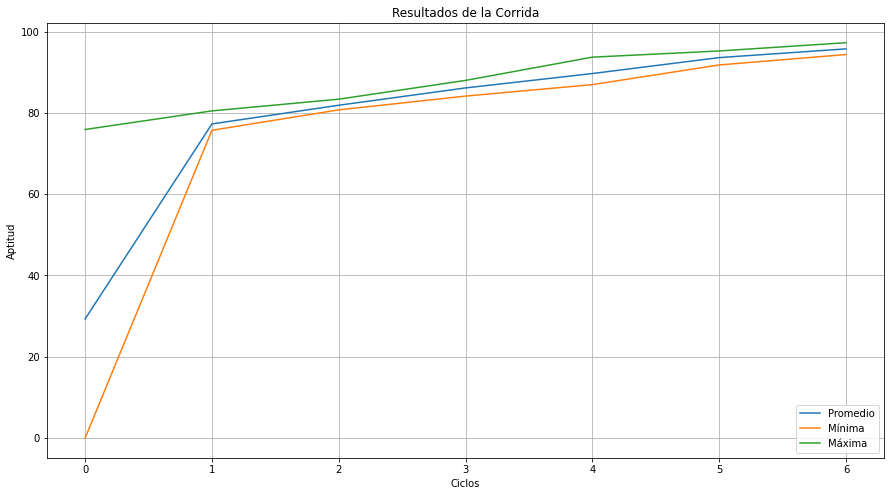

In [ ]:
#@title MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMinAptitud)
plt.plot(ciclosMaxAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud')
plt.legend(['Promedio', 'Mínima', 'Máxima'], loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
#@title MOSTRAR GRAFICO DE POSICIONES DE LOS INDIVIDUOS CICLO x CICLO

# Librerías especiales para usar
import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML

# método que se usa para generar gradiente de colores
def colorFader(c1, c2, mix=0.0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

# Método que se ejecuta por cada frame para mostrar 
def updatePlot(i, ciclosPos, scat, axi, posMejorCorrida, cicloMejorCorrida):
    if axi is None or ciclosPos is None:
      return scat,

    axi.set_xlabel('Ciclo: ' + str(i), fontsize=12)
      # Si no es el último ciclo, muestra también el global
    if i<len(ciclosPos):     
      if len(ciclosPos[i])>0:          
          if MOSTRAR_HISTORICO_MOVIMIENTO:
              # Coloca nuevas posiciones correspondientes al ciclo
              # Separa las coordenadas x, y de las posiciones en el ciclo i
              X, Y = zip(*ciclosPos[i])
              ## --en Rojo: posiciones de las particulas de cada ciclo
              axi.scatter(X, Y, color='red')
          else:
              # Hace mover a las Partículas
              scat.set_offsets(ciclosPos[i])              
    
    if i>=cicloMejorCorrida:
      if posMejorCorrida is not None:
          ## --en Violeta: Mejor posición de las partículas
          if len(posMejorCorrida) == 2 and isinstance(posMejorCorrida[0], int) and  isinstance(posMejorCorrida[1], int):
              axi.scatter(posMejorCorrida[0], posMejorCorrida[1], color='violet', s=100)
          else:
              X, Y = zip(*posMejorCorrida)                      
              axi.scatter(X, Y, color='violet', s=100)

    # Devuelve una lista de "artistas" para dibujar, 
    # en este caso es sólo uno por lo que se pone una coma final
    return scat,    

# Función para preparar el gráfico          
def PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosPos, partMejorCorrida, cicloMejorCorrida, textoTitulo, textoDesc):          

    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    plt.close()

    ## -- en Azul: Máximos Locales (positivos)
    ## -- en Cyan: Mínimos Locales (negativos)
    ## -- en Verde: Máximo Óptimo
    for posi, vali in zip(mapa.posMaximos, mapa.valMaximos):    
      valRel = abs(vali / mapa.valMaximoGlobal)
      if vali < 0:        
          c = colorFader('cyan', 'green', valRel) 
          ax.scatter(posi[0], posi[1], color=c)
      else:
          c = colorFader('blue', 'green', valRel) 
          ax.scatter(posi[0], posi[1], color=c)      
    ax.scatter(mapa.posMaximoGlobal[0], mapa.posMaximoGlobal[1], color='green', s=150)  
    
    # Define el tamaño de la figura
    ax.axis([MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ])

    # Separa las coordenadas x, y de las posiciones en el ciclo inicial
    X, Y = zip(*ciclosPos[0])
    ## --en Rojo: posiciones de las posiciones de cada ciclo
    scat = ax.scatter(X, Y, color='red')

    # Muestra título y texto debajo
    ax.set_title(textoTitulo)
    ax.set_ylabel(textoDesc, fontsize=11)

    # Luego setea la animación usando los dos métodos anteriores 
    cant = len(ciclosPos)+1
    ani = animation.FuncAnimation(fig, updatePlot, 
                                  frames=cant, interval=cant,
                                  fargs=(ciclosPos, scat, ax, partMejorCorrida, cicloMejorCorrida), 
                                  blit=True, repeat=False)
    
    return ani

# Define la configuración para el gráfico
MOSTRAR_HISTORICO_MOVIMIENTO = False
textoTitulo = "Posición de los Individuos del Algoritmo Memético ciclo x ciclo"
textoDesc = '\n** Posición Máximo Óptimo a buscar : ' + str(mapa.posMaximoGlobal) + ' { ' +  str(mapa.valMaximoGlobal) +' } **'
textoDesc = textoDesc + '\n== Mejor Individuo: ' + str(mejorIndCorrida) + ' { ' + str(round(mejorIndCorrida.fitness.values[0], 3)) + ' } =='
textoDesc = textoDesc + '\n-- Colores:  Máximos Locales (AZUL) - Máximo Óptimo (VERDE) - '  
textoDesc = textoDesc + '\n- Partículas (ROJO) - Mejor Individuo (VIOLETA) -- ' 

# Prepara el gráfico 
ani = PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosIndiv, mejorIndCorrida, mejorIndCorrida_ciclo, textoTitulo, textoDesc)    

# Nota: esto se agega para que funcione en Google Colab
rc('animation', html='jshtml')
display(ani)

In [ ]:
#@title EXPORTA EL GRAFICO ANTERIOR COMO UN VIDEO MP4
Exportar_Video_Animacion = False #@param {type:"boolean"}

if Exportar_Video_Animacion:
  from google.colab import files

  # Graba el gráfico anterior como un video MP4
  nomArchi = "MEME Corrida.mp4"
  ani.save('/' + nomArchi)
  try: 
    files.download('/' + nomArchi)
    print('Video ' + nomArchi + ' generado, debería bajarse automaticamente como un archivo local...')
  except ValueError:
    print('Error al intentar descargar el archivo ' + nomArchi)